<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_02_UNet_multiclass_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.02 UNet-Image segmentation

* 날짜:
* 이름:

## 학습내용
    - Image multiclass segmentation에 대해 이해한다.
    - 이미지 분절 작업을 수행한다.

## Muticlass Segmenation



<p  align='center'>
<img src ='https://miro.medium.com/max/1400/1*B16t8Do6hvuq2Q_2YOM-UQ.png' width=500>
</p>


<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0402-01.PNG?raw=true' width=800>
</p>


In [1]:
! git clone https://github.com/karolzak/keras-unet

Cloning into 'keras-unet'...
remote: Enumerating objects: 1234, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1234 (delta 44), reused 75 (delta 34), pack-reused 1136
Receiving objects: 100% (1234/1234), 31.94 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (372/372), done.


In [2]:
import sys, os, glob
sys.path.append('/content/keras-unet')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import utils, callbacks, models, layers
from keras_unet.models import custom_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## 데이터셋: Crowd Instance-level Human Parsing (CIHP)
---

(https://arxiv.org/abs/1811.12596)

* 38,280개의 다양한 인간 이미지
![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/chip.png?raw=true)

In [3]:
# 데이터셋
!gdown https://drive.google.com/u/4/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_&export=download

Downloading...
From: https://drive.google.com/u/4/uc?id=10p_-JQ8T7EuOJ1AWLSQpkUcrIhtRJgK_
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:28<00:00, 103MB/s]


In [4]:
!unzip -q instance-level-human-parsing.zip

# 데이터 전처리

In [16]:
# Training / Validation / Test
# 경로 구하기
data_dir = '/content/instance-level_human_parsing/instance-level_human_parsing/'
train_img_paths = sorted(glob.glob(f'{data_dir}/Training/Images/*'))
train_mask_paths = sorted(glob.glob(f'{data_dir}/Training/Category_ids/*'))
print(len(train_img_paths), train_img_paths[0])
print(len(train_mask_paths), train_mask_paths[0])

valid_img_paths = sorted(glob.glob(f'{data_dir}/Validation/Images/*'))
valid_mask_paths = sorted(glob.glob(f'{data_dir}/Validation/Category_ids/*'))
print(len(valid_img_paths), valid_img_paths[0])
print(len(valid_mask_paths), valid_mask_paths[0])

28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Images/0000006.jpg
28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Category_ids/0000006.png
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Images/0000001.jpg
5000 /content/instance-level_human_parsing/instance-level_human_parsing//Validation/Category_ids/0000001.png


In [6]:
# 이거는 좀 더 안전한 방법
#train_img_paths = [mask_path.replace('png', 'jpg') for mask_path in train_mask_paths]
#train_img_paths = [img_path.replace('Category_ids', 'Images') for img_path in train_img_paths]
#print(len(train_img_paths), train_img_paths[0])

28280 /content/instance-level_human_parsing/instance-level_human_parsing//Training/Images/0000006.jpg


### 첫번째 이슈 : 넘파이 배열로 데이터를 저장하기 무리가 있다.

In [7]:
imgs = []
masks = []
for img_path, mask_path in zip(train_img_paths[:10], train_mask_paths[:10]):
  # path2img
  img = Image.open(img_path).resize( (128,128) )
  img = np.array(img)
  imgs.append(img)
  # path2mask
  mask = Image.open(mask_path).resize( (128,128) )
  mask = np.array(mask)
  masks.append(mask)
imgs = np.asarray(imgs)
masks = np.asarray(masks)
masks = np.expand_dims(masks, 3)

imgs.shape, masks.shape

((10, 128, 128, 3), (10, 128, 128, 1))

In [8]:
len(train_img_paths)

28280

In [136]:
# for 루프 대신에 map을 사용
# map에 들어갈 함수 특징: 리스트가 아니라 scalar 를 받는다.
def path2tensor(image_path, mask_path, IMAGE_SIZE=128): # 이미지 경로 한개, 마스크 경로 한개
  # 이미지 처리
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image.set_shape([None, None, 3])
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  image = image / 255.

  # 마스크 처리
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask.set_shape([None, None, 1])
  mask = tf.image.resize(images=mask, size=[IMAGE_SIZE, IMAGE_SIZE])

  return image, mask

def aug(image, mask, seed=123): 
  image = tf.image.random_brightness(image, 0.2) # 랜덤 밝기 -> 이미지
  image = tf.image.random_contrast(image, 0.2, 0.5 )# 랜덤 대비 -> 이미지  
  # 이미지-마스크 같이 변환
  stacked = tf.concat([image, mask], axis=2)
  # 랜덤 좌우 반전 
  stacked = tf.image.random_flip_left_right(stacked, seed=seed)
  # 랜덤 상하 반전
  stacked = tf.image.random_flip_up_down(stacked, seed=seed)

  image = stacked[:,:,:3]
  mask = tf.reshape(stacked[:,:,-1], (128,128,1))
  return image, mask

def cast_mask(image, mask):
  mask = tf.cast(mask, dtype=tf.uint8)
  return image, mask

(TensorShape([128, 128, 3]), TensorShape([128, 128, 1]))

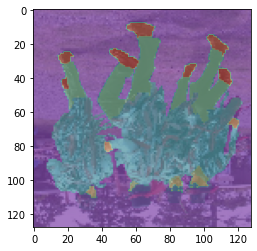

In [134]:
img, mask = path2tensor(train_img_paths[2], train_mask_paths[2], mode='train')
plt.imshow(img);plt.imshow(mask[:,:,0], alpha=.3, cmap='rainbow')
img.shape, mask.shape

In [137]:
train_ds = tf.data.Dataset.from_tensor_slices((train_img_paths, train_mask_paths))
train_ds = train_ds.map(path2tensor, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(aug)
train_ds = train_ds.map(cast_mask)
train_ds = train_ds.batch(32, drop_remainder=True)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_mask_paths))
valid_ds = valid_ds.map(path2tensor, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(cast_mask)
valid_ds = valid_ds.batch(32, drop_remainder=True)

print(train_ds)
print(valid_ds)

<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.uint8, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.uint8, name=None))>


In [ ]:
# 데이터 증강

### 두번째 이슈 : 플로팅 다시 

(32, 128, 128, 3) (32, 128, 128, 1)


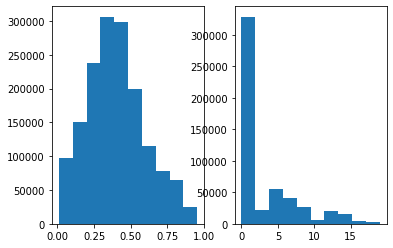

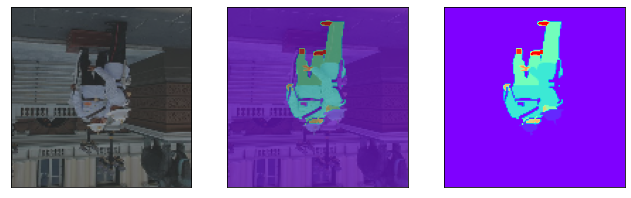

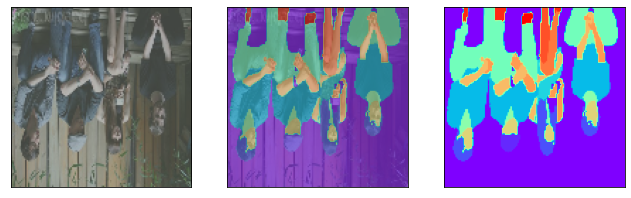

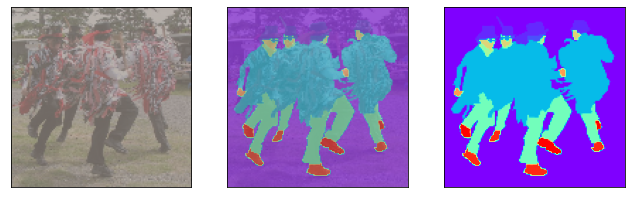

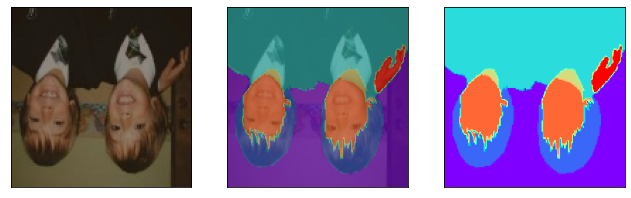

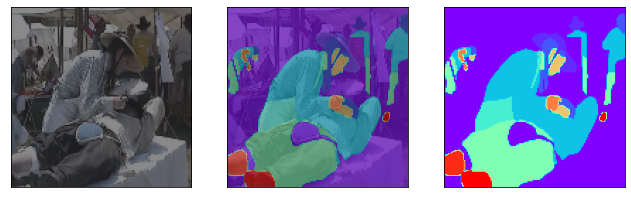

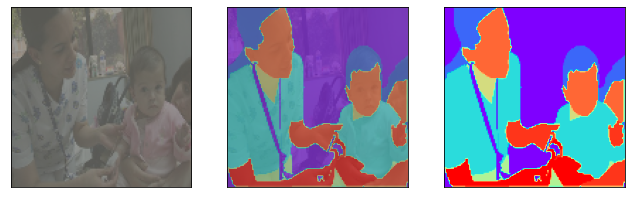

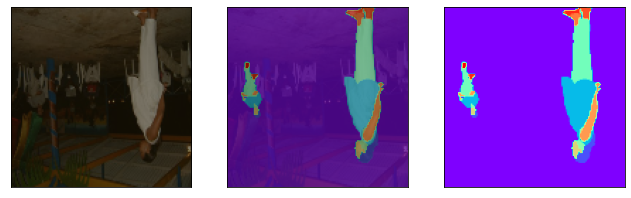

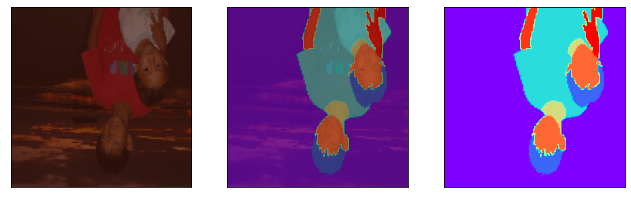

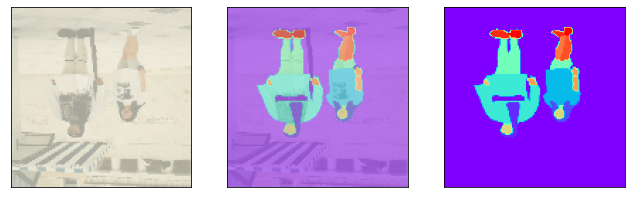

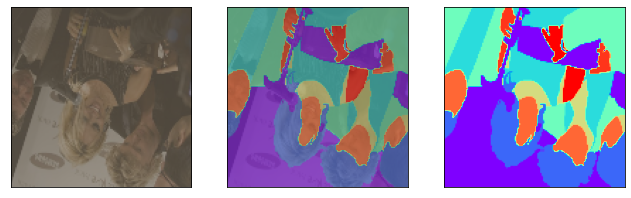

In [99]:
for imgs, masks in train_ds.take(1):
  print(imgs.shape, masks.shape)
  N = 10
  plt.subplot(121);_=plt.hist(tf.reshape(imgs, [-1]))
  plt.subplot(122);_=plt.hist(tf.reshape(masks, [-1]))
  plt.show()
  for img, mask in zip(imgs[:N], masks[:N]):
    plt.figure(figsize=(11,4))
    plt.subplot(131);plt.imshow(img);plt.xticks([]);plt.yticks([])
    plt.subplot(132);plt.imshow(img);plt.imshow(mask[:,:,0], alpha=.5, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(133);plt.imshow(mask[:,:,0], cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.show()

## 모델 준비
--- 

In [114]:
model = custom_unet((128,128,3),
                    num_classes=20,
                    filters=32, 
                    output_activation='softmax',
                    )
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 32  128        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [115]:
# 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
ckp = callbacks.ModelCheckpoint(filepath='model.h5',
                                save_best_only=True,
                                monitor='val_loss')
tb = callbacks.TensorBoard(log_dir='my_log_dir', histogram_freq=1) 
model.fit(train_ds,
          epochs=50,
          validation_data=valid_ds,
          callbacks=[ckp, tb])

### 결과 확인

In [145]:
model = models.load_model('model.h5')

(32, 128, 128, 1) (32, 128, 128)


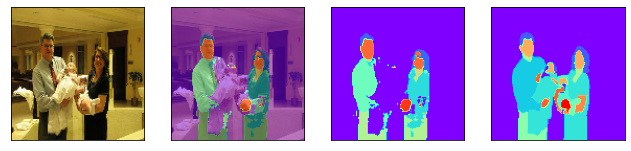

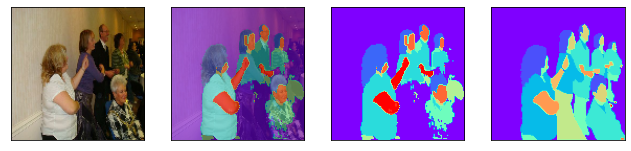

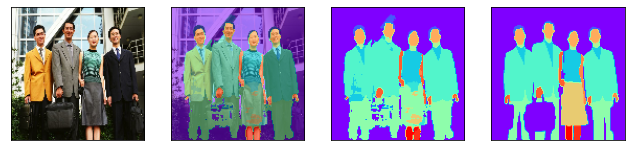

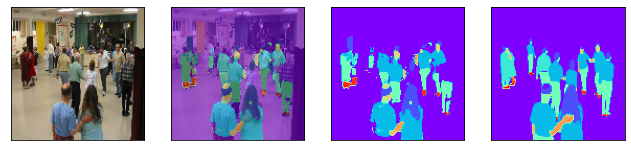

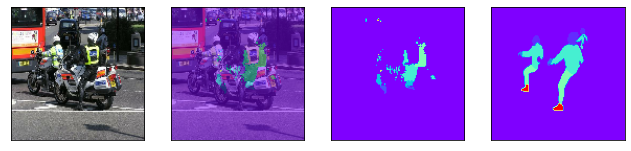

In [147]:
for imgs, masks in valid_ds.take(1):
  N = 5
  preds = model.predict(imgs)
  preds = tf.argmax(preds, 3)
  print(masks.shape, preds.shape)
  for img, mask, pred in zip(imgs[:N], masks[:N], preds[:N]):
    plt.figure(figsize=(11,4))
    plt.subplot(141);plt.imshow(img);plt.xticks([]);plt.yticks([])
    plt.subplot(142);plt.imshow(img);plt.imshow(pred, alpha=.5, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(143);plt.imshow(pred, cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.subplot(144);plt.imshow(mask[:,:,0], cmap='rainbow');plt.xticks([]);plt.yticks([])
    plt.show()